In [23]:
# Synapse Classification Challenge
# Introduction to Connectomics 2018
# Gautam Prabhu

your_name = 'prabhu_gautam'

In [24]:
!pip install -U pip
!pip install mahotas
!pip install ndparse
!pip install -U scikit-image
%matplotlib inline

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: scikit-image in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: networkx>=1.8 in /opt/conda/lib/python3.6/site-packages (from scikit-image)
Requirement already up-to-date: pillow>=2.1.0 in /opt/conda/lib/python3.6/site-packages (from scikit-image)
Requirement already up-to-date: six>=1.7.3 in /opt/conda/lib/python3.6/site-packages (from scikit-image)
Requirement already up-to-date: matplotlib>=1.3.1 in /opt/conda/lib/python3.6/site-packages (from scikit-image)
Requirement already up-to-date: scipy>=0.17.0 in /opt/conda/lib/python3.6/site-packages (from scikit-image)
Requirement already up-to-date: PyWavelets>=0.4.0 in /opt/conda/lib/python3.6/site-packages (from scikit-image)
Requirement already up-to-date: decorator>=4.1.0 in /opt/conda/lib/python3.6/site-packages (from networkx>=1.8->scikit-image)
Requirement already up-to-date: pytz in /opt/conda/lib/p

In [25]:
# Load data

import numpy as np

data = np.load('./synchallenge2017_training.npz')

imtrain = data['imtrain']
annotrain = data['annotrain']
ytrain = data['ytrain']

data = np.load('./synchallenge2017_validation.npz')

imvalid = data['imvalid']
annovalid = data['annovalid']
yvalid = data['yvalid']

In [26]:
# Define feature extraction code

import skimage
import skimage.feature as skif

def extract_features(imdata):
    xtrain = []
    for im in imdata:
        fvector = []
        
        # 50th percentile based on intensity
        fvector.append(np.percentile(im,50))

        # add a contrast feature
        g = skif.greycomatrix(im, [1, 2], [0, np.pi/2],normed=True, symmetric=True)
        
        #greyscale comatrix features (texture)
        homogeneity = skif.greycoprops(g, 'homogeneity')
            
        homogeneity = np.ravel(homogeneity)
        for i in homogeneity:
            fvector.append(i)
            
        #structure tensor - recognizes edges
        Axx, Axy, Ayy = skif.structure_tensor(im, sigma = 2.5)
        l1,l2 = skif.structure_tensor_eigvals(Axx,Axy,Ayy)
        
        l1 = np.ravel(l1) # greatest eigenvalues
        for i in l1:
            fvector.append(i)
            
        l2 = np.ravel(l2)
        for i in l2:
            fvector.append(i)
            
        #hessian - recognizes curvature
        Hxx, Hxy, Hyy = skif.hessian_matrix(im, sigma=3.5, order="xy")
        i1 = skif.hessian_matrix_eigvals(Hxx,Hxy,Hyy)
        dets = skif.hessian_matrix_det(im, sigma=3)
        
        i1 = np.ravel(i1) #greatest eigenvalues
        for i in i1:
            fvector.append(i)
            
        dets = np.ravel(dets) #determinants of hessians
        for i in dets:
            fvector.append(i)
            
        can = skif.canny(im) #edge detector
        sum_edges = 0
        for i in np.ravel(can):
            sum_edges += i
        fvector.append(sum_edges)

        fvector = np.asarray(fvector)
        xtrain.append(fvector)

    return np.asarray(xtrain)
    

In [27]:
# Extract Features from training

xtrain = extract_features(imtrain)
# Train Classifier

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(xtrain, ytrain)


/opt/conda/lib/python3.6/site-packages/skimage/feature/texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


In [28]:
# Extract features from validation set
xvalid = extract_features(imvalid)


/opt/conda/lib/python3.6/site-packages/skimage/feature/texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):


In [29]:
# Run Classifier on validation set
scoresvalid = clf.predict_proba(xvalid)

In [30]:
# Best f1 score report on validation set

from sklearn.metrics import f1_score

# Can add post-processing here if desired

prob_syn = scoresvalid[:,1]

# default threshold
print('default f1 score: {}'.format(np.round(f1_score(yvalid, prob_syn >=0.5),2)))

f1_out = 0
thresh = 0
for i in np.arange(0.0, 1, 0.05): #0 to 1 by 0.05
    f1_test =  f1_score(yvalid, prob_syn > i) #cutoff point for decision
    if f1_test > f1_out:
        f1_out = f1_test
        thresh = i

print('My best validation f1-score is: {} at {} threshold.'.format(np.round(f1_out,2), thresh))

default f1 score: 0.89
My best validation f1-score is: 0.9 at 0.45 threshold.


synapse present - true positive


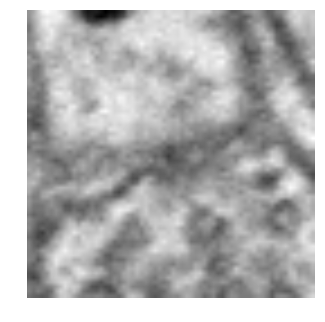

no synapse present - true negative


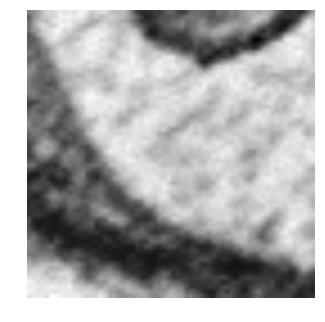

synapse present - false negative


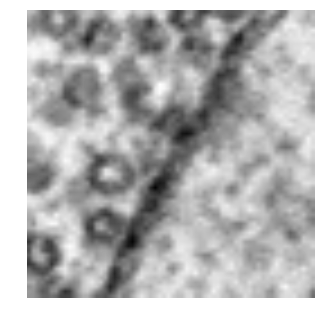

no synapse present - false positive


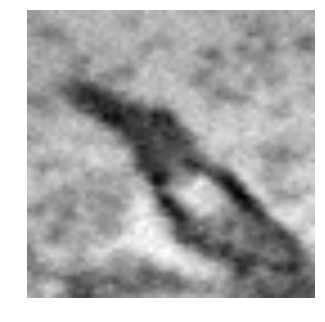

In [ ]:
# here we can inspect results

valid_labels = np.asarray(prob_syn > thresh,dtype='int')
# find images we did well on
idx_correct_syn = np.where((valid_labels == yvalid) & (yvalid == 1))[0]
idx_correct_nosyn = np.where((valid_labels == yvalid) & (yvalid == 0))[0]
# find images we did poorly on

idx_wrong_syn = np.where((valid_labels != yvalid) & (yvalid == 1))[0]
idx_wrong_nosyn = np.where((valid_labels != yvalid) & (yvalid == 0))[0]
import ndparse as ndp

print('synapse present - true positive')
ndp.plot(imvalid[idx_correct_syn[3]])

print('no synapse present - true negative')
ndp.plot(imvalid[idx_correct_nosyn[3]])

print('synapse present - false negative')
ndp.plot(imvalid[idx_wrong_syn[3]])

print('no synapse present - false positive')
ndp.plot(imvalid[idx_wrong_nosyn[3]])

In [ ]:
# Validate performance on test set (should only run/score once!)

data = np.load('./synchallenge2017_test_notruth.npz')

imtest = data['imtest']
annotest = data['annotest']

# Extract features from test set
xtest = extract_features(imtest)

# Run classifier on test set
scoretest = clf.predict_proba(xvalid)

# Post-processing
prob_syntest = scoretest[:,1]
syntest_predict = prob_syntest > thresh
syntest_predict = np.asarray(syntest_predict,dtype = 'uint8')

# save file and upload to google docs with label vector
np.save(your_name+'_synchallenge_testdata.npy',syntest_predict)

/opt/conda/lib/python3.6/site-packages/skimage/feature/texture.py:109: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(image.dtype, np.float):
